# Trabajo Práctico final
### Grupo 5 
* Diego Ciarrapico
* Diego Castro
* Paula Mainini
* Fanny Chuchuca
* Facundo Ponce
* Marcos Kippes 


In [1]:
#importación de todas las librerias usadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,auc,roc_curve
import warnings
warnings.filterwarnings("ignore")

### Definición de una función que grafique la curva roc y calcule el área bajo la curva para modelo multiclases

Al tener una variable target multiclase, y siendo condicion necesaria para la graficacion de la curva ROC y el AUC, variables target binarias se decidió realizar una función que:
* Se pueda usar en todos los modelos
* Realice una curva y calcule el auc por cada clase con la siguiente metodología: utiliza la prediccion del modelo para cada clase y modifica el y_test en 1 cuando es la clase actual y en 0 cuando es cualquier tipo de otra clase
* De esta manera se esta midiendo sensibilidad y especificidad para la clase (i) tomandola como 1 contra con el resto que será 0

In [2]:
def curva_roc_cada_clase(model, X,y_test):
    #defino un array para los nombres de las clases 
    global clases
    #obtengo el predict_proba del modelo para todas las clases
    y_pred_test_proba = model.predict_proba(X)
    # en el rango del tamaño de la cantidad de columnas del predict_proba, es decir de las clases que haya encontrado
    #recordando que el predict proba me tira una columna por cada clase, en donde pone la probabilidad de esa instancia de pertenecer a esa clase
    for i in range(y_pred_test_proba.shape[1]):
        proba_clase_i = y_pred_test_proba[:, i] #me quedo con la probabilida de la clase actual en el for
        y_test_i = (y_test== i).astype(np.int32) #cambio y test, dará 1 cuando sea la clase actual y 0 cuando sea cualquier otra clase
        
        #graficando la roc curve
        fpr, tpr, thr = roc_curve(y_test_i, proba_clase_i) #desempaqueto la roc curve
        roc_auc = auc(fpr, tpr)
        print('AUC: '+str(clases[i])+' '+str(roc_auc))
        df = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thr = thr)) #creo el dataframe
        plt.axis([0, 1.007, 0, 1.007])
        plt.xlabel('1 - Especificidad')
        plt.ylabel('TPR / Sensitividad')
        plt.title(f'Curvas ROC 1 vs rest') #pongo el titulo para saber de que clase estoy hablando
        plt.plot(df['fpr'],df['tpr'],label=f'ROC clase {clases[i]} (area = {round(roc_auc,3)})')
        plt.legend(loc="lower right")
        
        #imprimo el area bajo la curva para cada clase
    plt.plot(np.arange(0,2, step =0.01), np.arange(0,2, step =0.01))
    plt.show()

## Información sobre el dataset

El dataset contiene información sobre distintas características de celulares. El objetivo de la presente notebook será predecir la variable target que es, el rango de precio.

Variables:

| Columna         | Descripción                                                                                   |
|-----------------|-----------------------------------------------------------------------------------------------|
| battery_power   | Energía total que puede almacenar la batería (mAh)                                            |
| blue            | El dispositivo tiene Bluetooth o no, sí/no (1/0)                                               |
| clock_speed     | La velocidad de ejecución de instrucciones por el microprocesador                              |
| dual_sim        | El dispositivo tiene dos ranuras para tarjetas SIM o no                                        |
| fc              | Calidad de la cámara frontal en megapíxeles                                                     |
| four_g          | El dispositivo tiene capacidad de red 4G o no                                                  |
| int_memory      | Capacidad de memoria interna en gigabytes                                                       |
| m_dep           | La profundidad del dispositivo en centímetros                                                   |
| mobile_wt       | El peso del dispositivo en gramos                                                              |
| n_cores         | El número de núcleos del procesador                                                             |
| pc              | Calidad de la cámara principal en megapíxeles                                                    |
| px_height       | La altura de la resolución de píxeles                                                            |
| px_width        | El ancho de la resolución de píxeles                                                             |
| ram             | Capacidad de memoria RAM en megabytes                                                           |
| sc_h            | La altura de la pantalla del dispositivo en centímetros                                          |
| sc_w            | El ancho de la pantalla del dispositivo en centímetros                                           |
| talk_time       | El tiempo máximo de conversación que puede soportar la batería completamente cargada del dispositivo |
| three_g         | El dispositivo tiene capacidad de red 3G o no                                                   |
| touch_screen    | El dispositivo tiene pantalla táctil o no                                                       |
| wifi            | El dispositivo tiene capacidad Wi-Fi o no                                                        |
| price_range     | El rango de precio categorizado del dispositivo

Leemos el dataset

In [3]:
df = pd.read_csv('CellPhone.csv')
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [4]:
df.shape

(2000, 21)

El dataset cuenta con 2000 registros y 22 columnas

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [6]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [7]:
df.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

### Variable target

Cambiamos la categoría númerica de las clases por el significado de cada una para aumentar la interpretabilidad del modelo 

In [8]:
clases={0:'Gama Baja',1:'Gama Media',2:'Gama Media-Alta',3:'Gama Alta'}

In [9]:
target='price_range'

In [10]:
df['target_num']=df[target]
df[target]=df[target].map(clases)

In [11]:
targets=[target,'target_num']
targets

['price_range', 'target_num']

In [12]:
df[target].value_counts()

Gama Baja          500
Gama Media-Alta    500
Gama Media         500
Gama Alta          500
Name: price_range, dtype: int64

In [13]:
df[target].value_counts(normalize=True)

Gama Baja          0.25
Gama Media-Alta    0.25
Gama Media         0.25
Gama Alta          0.25
Name: price_range, dtype: float64

La variable target consta de 4 categorías de precio y está balanceada

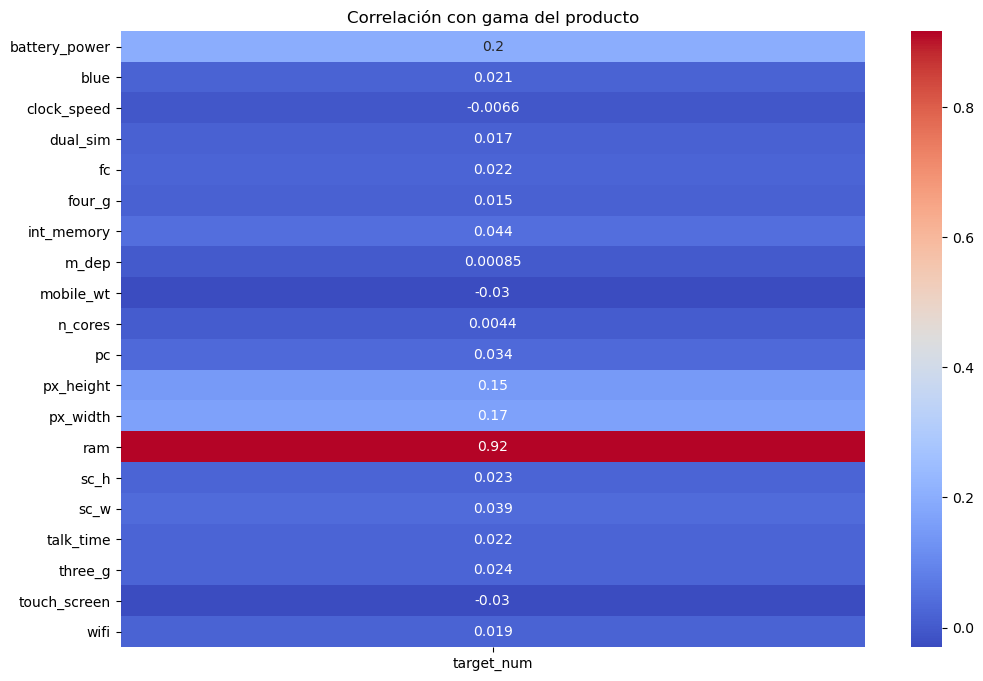

In [14]:
#graficando la correlacion de las variables con la variable target
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr()['target_num'].iloc[0:df.corr()['target_num'].shape[0]-1].to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlación con gama del producto')
plt.show()

La variable que más correlaciona con price_range es ram (0.92). Seguido a esta, pero lejos en relación, encontramos battery_power, px_height, px_width

Buscamos ver estas correlaciones por medio de un scatterplot

<AxesSubplot:xlabel='price_range', ylabel='ram'>

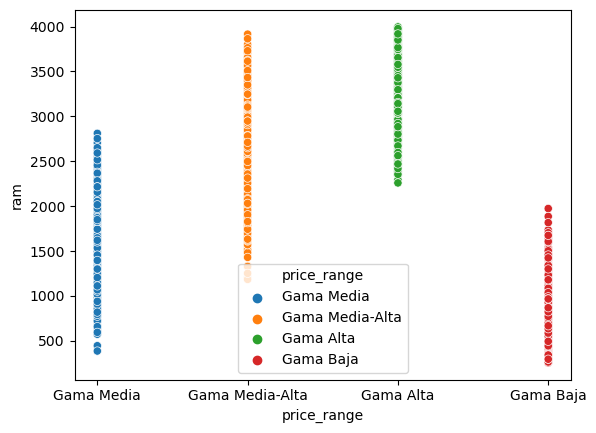

In [15]:
#graficando un scatterplot entre price_range y ram que tienen una alta correlación
sns.scatterplot(data=df, x=target, y='ram', hue=target)

<AxesSubplot:xlabel='price_range', ylabel='battery_power'>

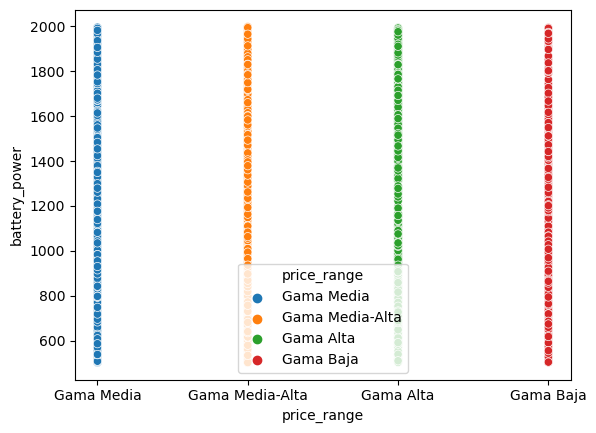

In [16]:
#graficando un scatterplot entre price_range y battery_power
sns.scatterplot(data=df, x=target, y='battery_power', hue=target)

<AxesSubplot:xlabel='price_range', ylabel='px_height'>

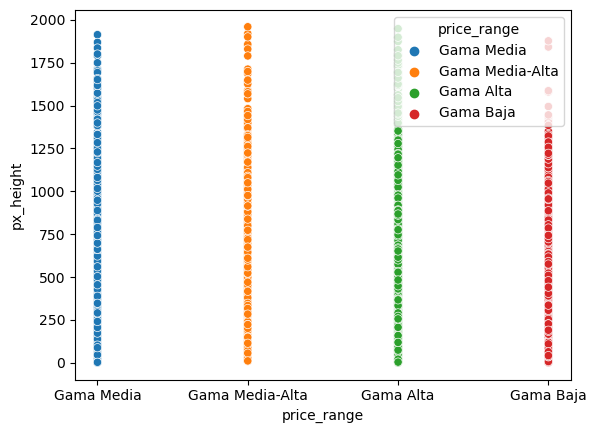

In [17]:
#graficando un scatterplot entre price_range y battery_power
sns.scatterplot(data=df, x=target, y='px_height', hue=target)

Es clara la diferenciación de precios según ram, pero no así con la potencia de la bateria y el tamaño del celular

### Division entre train y test

In [18]:
X = df.drop([target,'target_num'], axis = 1)
Y = df['target_num']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1237)

### Separando columnas categóricas de númericas

Hay algunas columnas que si bien son númericas, denotan presencia o ausencia de alguna característica, se filtra como categorica si tiene 2 valores únicos (esto se deduce del análisis previo del dataset, sin este, el número para filtrar categóricas debería ser más alto)

In [19]:
categorical_columns = [col for col in df.columns if len(df[col].unique()) == 2 and col not in targets]
categorical_columns

['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

In [20]:
numerical_columns = [col for col in df.columns if col not in categorical_columns and col not in targets]
if target in numerical_columns : numerical_columns.remove(target)
numerical_columns

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

Paso las columnas categoricas a object para poder usar el One Hote Encoder

In [21]:
for col in categorical_columns:
    df[col]=df[col].astype('str')

# PCA

Ahora buscamos implementar al dataset un PCA. <br>
Uno de los objetivos de aplicar Principal Component Analysis es reducir la dimensionalidad del dataset, es decir, identificar y seleccionar las variables más relevantes para el entrenamiento de los modelos, en otras palabras, remover las variables poco informativas o relevantes, <br>
Esto lo hace combinando las variables originales a través de álgebra lineal, dando origen a componentes principales

El PCA, se realiza sobre variables númericas que deben ser previamente estandarizadas

In [22]:
# Estandarizo los datos númericos para poder realizar PCA
std_sclr = StandardScaler()
std_sclr_trained = std_sclr.fit(X_train[numerical_columns])
X_train_numerical = std_sclr_trained.transform(X_train[numerical_columns])
X_train_numerical_scaled = pd.DataFrame(X_train_numerical, columns = numerical_columns)
X_train_numerical_scaled.head()
X_test_numerical = std_sclr_trained.transform(X_test[numerical_columns])
X_test_numerical_scaled = pd.DataFrame(X_test_numerical, columns = numerical_columns)
X_test_numerical_scaled.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
0,-1.109552,0.187695,-0.995375,0.068600,0.003461,-1.019632,-0.243837,-1.320262,1.364498,1.644085,0.547334,-0.784926,-0.648022,1.434057
1,-0.509412,1.165456,-0.303456,0.233147,1.733792,-0.905884,-1.560178,0.671692,0.402996,1.665027,-0.948465,-1.496493,-0.420873,-0.929630
2,0.438536,-1.156726,-0.995375,0.068600,0.003461,-1.474626,-0.682617,-1.320262,-0.563009,0.911120,1.538057,-0.547737,-0.648022,-0.384164
3,-0.845854,0.065475,2.002940,0.891334,0.003461,1.312210,1.072505,1.335676,-0.700367,0.480649,-0.220454,1.112586,-0.875170,1.252235
4,-0.500319,-1.278946,-0.072816,0.397694,-1.380805,0.572845,-0.243837,-0.656278,0.531346,-0.142953,0.641688,-1.022115,-1.329467,-0.202342


Aplico PCA con los datos de train ya escalados e imprimo la varianza explicada. La varianza explicada da cuánta información captura cada componente principal.


[0.12123523 0.11520267 0.09927839 0.07780479 0.07550814 0.07305091
 0.07247733 0.07039236 0.06822978 0.0672736  0.06417257 0.03593311
 0.03345908 0.02598204]
[0.12123523 0.2364379  0.33571629 0.41352108 0.48902922 0.56208013
 0.63455746 0.70494982 0.7731796  0.8404532  0.90462577 0.94055888
 0.97401796 1.        ]


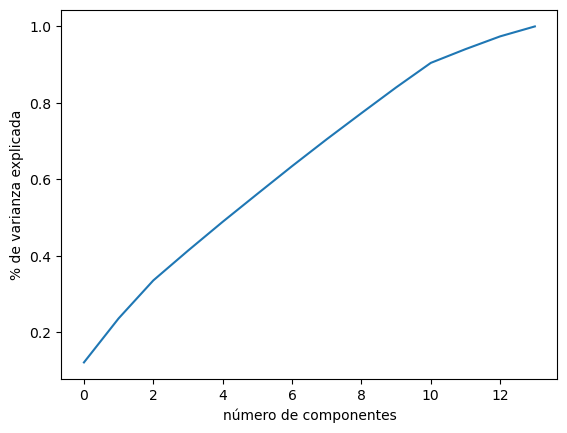

In [23]:
#Realizo PCA
model_pca = PCA().fit(X_train_numerical_scaled)
explained_variance = model_pca.explained_variance_ratio_
print(explained_variance)
cumulative_explained_variance = np.cumsum(explained_variance)
print(cumulative_explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('número de componentes')
plt.ylabel('% de varianza explicada');

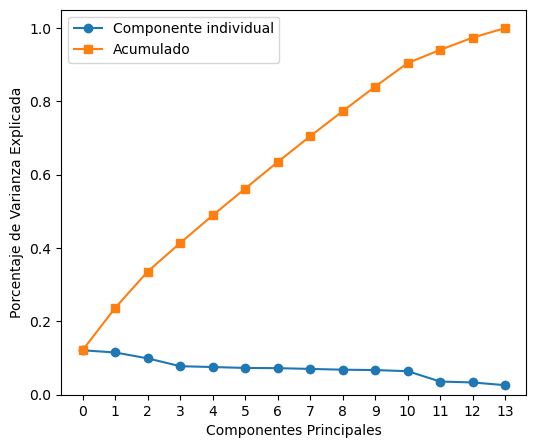

In [24]:
plt.figure(figsize=(6,5))

plt.plot(range(14), model_pca.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(range(14), np.cumsum(model_pca.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(0,1.05); plt.xticks(range(14))
plt.legend(loc=0);

### Conclusión de PCA
Usualmente en un gráfico de este tipo veríamos la posibilidad de usar la técnica del bastón quebrado, que nos indica con qué números de componentes deberíamos quedarnos, es donde se estabiliza el descenso. 
En este caso, el bastón quebrado se ve en el componente 10.
No parece ser una reducción significativa el pasar de 12 a 10 variables númericas. 
Teniendo en cuenta esto, se decide usar todas las variables para encontrar al mejor modelo de ensamble, priorizando el no perder la interpretabilidad de las features a cambio de reducir sólo 2 dimensiones. 
Una vez encontrado el mejor modelo de ensamble, se buscará reducir la dimensionalidad con otro método (RFECV)

## Buscando el mejor modelo de ensamble

Se realizará una búsqueda de el mejor modelo de ensamble. <br>
Esto será a partir de un Pipeline combinado con grid search, en donde se pase a dummies las variables categóricas por medio de OneHotEncoder, se buscará el mejor tipo de estandarización para las features númericas y se seleccionara el modelo de ensamble por default que mejor rinda, para luego encontrar los mejores hiperpárametros con un gridsearch

In [25]:
# Definó los folds que se usarán en todas las validaciones cruzadas
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [26]:
#Creando un ColumnTransformer que estandarize las columnas númericas, en principio con un StandarScales 
#y pase a dummies las categoricas con onehotencoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

Hago un pipeline donde combino el preprocesamiento de los datos y el modelo. <br>

Busco con un grid search qué modelo de ensamble es mejor y con qué tipo de escala

In [27]:
# Creo el pipeline con el preprocesador definido anteriormente y un modelo de base (randomforest)
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modelo', RandomForestClassifier())
])

# Defino la grilla en donde busque el mejor escalador y el mejor modelo de ensamble
param_grid = {
    'modelo': [RandomForestClassifier(), BaggingClassifier(),ExtraTreesClassifier(),GradientBoostingClassifier(),XGBClassifier(),AdaBoostClassifier()]
}

grid = GridSearchCV(pipe, param_grid, cv=folds)

grid.fit(X_train, Y_train)

[17:48:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:07] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['battery_power',
                                                                          'clock_speed',
                                                                          'fc',
                                                                          'int_memory',
                                                                          'm_dep',
                                                                          'mobile_wt',
                                                                          'n_cores',
                                                                          'pc',
              

In [28]:
grid.best_estimator_['modelo']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

El mejor modelo según el GridSearch es XGBClassifier. Con esto ya determinado, busco qué parametros son los mejores en este modelo

Para mejor precisión en multiclases se cambia el objective para mejorar el accuracy y para obtener consistencia para utilizar la función de curvas ROC

Se utiliza un RandomizedSearch para reducir el poder de computo considerablemente

In [29]:
pipe_XGB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',objective='multi:softmax'))
])


param_random_XGB = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    'XGB__n_estimators': [100, 200, 500],
    'XGB__max_depth': [3, 5, 7],
    'XGB__learning_rate': [0.01, 0.1, 0.3],
    'XGB__subsample': [0.8, 1.0],
    'XGB__colsample_bytree': [0.8, 1.0],
    'XGB__gamma': [0, 0.1, 0.2],
    'XGB__reg_alpha': [0, 0.01, 0.1],
    'XGB__reg_lambda': [1, 1.5, 2]
}


randomized = RandomizedSearchCV(pipe_XGB, param_random_XGB, cv=folds,n_jobs=-1,verbose=1, random_state=12)

randomized.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min


Veo la importancia de las features del modelo

In [ ]:
print("Mejores parámetros encontrados:", randomized.best_params_)
print("Mejor puntaje de validación cruzada:", randomized.best_score_)
model_XGB=randomized.best_estimator_

Mejores parámetros encontrados: {'preprocessor__num': MinMaxScaler(), 'XGB__subsample': 0.8, 'XGB__reg_lambda': 1, 'XGB__reg_alpha': 0.01, 'XGB__n_estimators': 500, 'XGB__max_depth': 3, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0, 'XGB__colsample_bytree': 1.0}
Mejor puntaje de validación cruzada: 0.912857142857143


In [ ]:
model_XGB

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('XGB',


## Evaluación de la performance del modelo

In [ ]:
accuracy_score(Y_test,model_XGB.predict(X_test))

0.905

El accuracy general del modelo es de 0.905, es decir clasifico el 91% de casos correctamente. 


AUC: Gama Baja 0.9976629650542693
AUC: Gama Media 0.9819934758970641
AUC: Gama Media-Alta 0.976445080310919
AUC: Gama Alta 0.9956398706398707


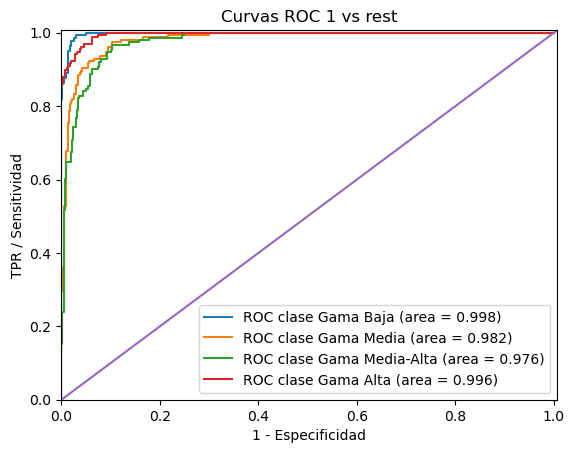

In [ ]:
curva_roc_cada_clase(model_XGB, X_test,Y_test)  

Las curvas ROC nos muestra que el modelo performa de buena manera, ninguna curva está por debajo de un 97%.
Tanto la clase baja como la clase alta fueron clasificadas casi de manera perfecta (99 de AUC), mientras que las 2 intermedias (media y media-alta) también tuvieron una performance excelente pero disminuyeron un poco.

Text(0.5, 23.52222222222222, 'Clase Predicha')

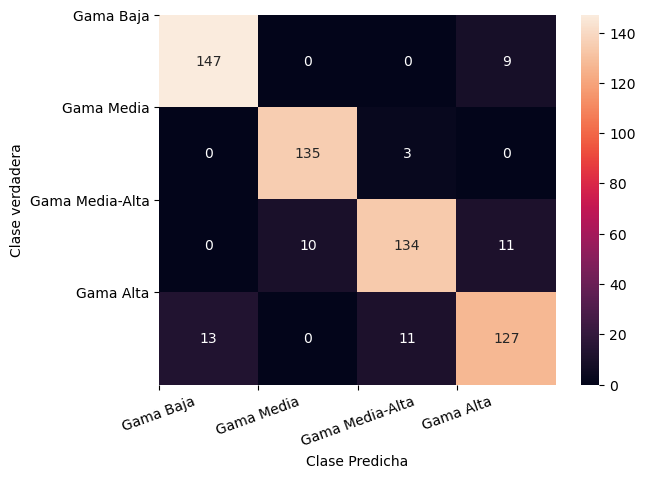

In [ ]:
conf_mat = confusion_matrix(Y_test.map(clases), pd.Series(model_XGB.predict(X_test)).map(clases))
sns.heatmap(conf_mat,annot=True,fmt='.4g')
plt.xticks(np.arange(len(list(clases.values()))), list(clases.values()),rotation=20)
plt.yticks(np.arange(len(list(clases.values()))), list(clases.values()),rotation=0)
plt.ylabel('Clase verdadera')
plt.xlabel('Clase Predicha')

En concordancia con las curvas ROC, se puede observar que las clases intermedias son las más dificil de predecir.


In [ ]:
print (classification_report(Y_test.map(clases), pd.Series(model_XGB.predict(X_test)).map(clases)))

                 precision    recall  f1-score   support

      Gama Alta       0.92      0.94      0.93       156
      Gama Baja       0.93      0.98      0.95       138
     Gama Media       0.91      0.86      0.88       155
Gama Media-Alta       0.86      0.84      0.85       151

       accuracy                           0.91       600
      macro avg       0.90      0.91      0.91       600
   weighted avg       0.90      0.91      0.90       600



* La clase Gama Alta tiene una sensibilidad o recall del 94%, es decir de todos los casos positivos de esa clase clasifico correctamente el 94% de ellos. La precisión, es decir, con cuánta frecuencia acierta cuando se predice que la clase es Gama Alta, es de un 92%
* La clase Gama Baja tiene una sensibilidad o recall del 98%, es decir de todos los casos positivos de esa clase clasifico correctamente el 98% de ellos (Esto es la recall más alta de las clases). La precisión, es decir, con cuánta frecuencia acierta cuando se predice que la clase es Gama Baja, es de un 93%
* La clase Gama Media tiene una sensibilidad o recall del 86%, es decir de todos los casos positivos de esa clase clasifico correctamente el 86% de ellos. La precisión, es decir, con cuánta frecuencia acierta cuando se predice que la clase es Gama Meida, es de un 91%
* La clase Gama Media-Alta tiene una sensibilidad o recall del 84%, es decir de todos los casos positivos de esa clase clasifico correctamente el 84% de ellos. La precisión, es decir, con cuánta frecuencia acierta cuando se predice que la clase es Gama Media-Alta, es de un 86%
* La clase mejor predicha es la Gama Baja, y la peor, la Media-Alta. Igualmente podemos decir que los puntajes son altos en todas las clases

### Feature importance y reducción de la dimensionalidad con RFECV
Ahora que ya tenemos el modelo entrenado y evaluado, buscamos dar cuenta de cuáles son las features más importantes en este modelo, es decir, qué features son las que más determinan la clase predicha. 

In [ ]:
rf_select = pd.DataFrame({'atributo':X.columns, 'importancia': randomized.best_estimator_['XGB'].feature_importances_})
rf_select.sort_values('importancia', ascending = False)

,atributo,importancia
10,pc,0.378401
0,battery_power,0.107085
8,mobile_wt,0.089270
9,n_cores,0.068805
5,four_g,0.031837
2,clock_speed,0.031068
17,three_g,0.026803
6,int_memory,0.025881
12,px_width,0.025454
3,dual_sim,0.024724


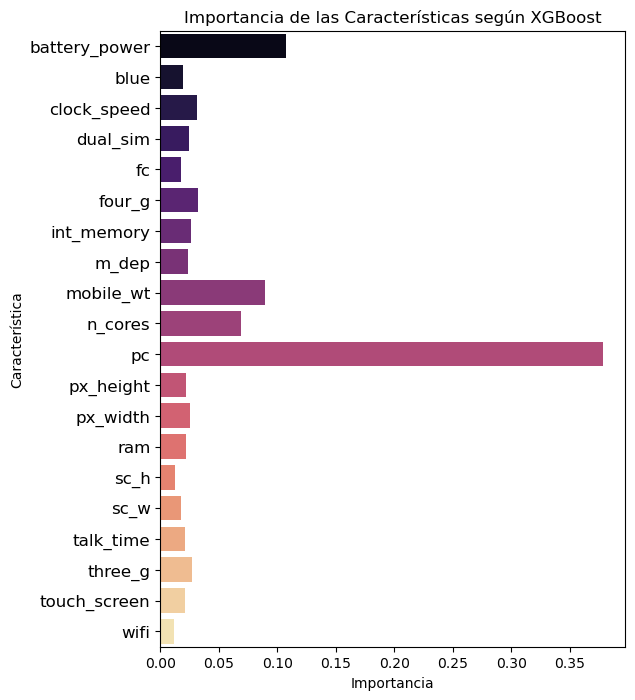

In [ ]:
plt.figure(figsize=(6, 8))
sns.barplot(x='importancia', y='atributo', data=rf_select.sort_values('atributo'), palette='magma')
plt.title('Importancia de las Características según XGBoost')
plt.yticks(fontsize=12)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

Ahora, aplicamos el método RFECV. Este método determina la cantidad de features a seleccionar usando CrossValidation según la importancia de cada feature

In [ ]:
estimator = randomized.best_estimator_['XGB']
kf = StratifiedKFold(n_splits = 5, shuffle = True)

rfecv = RFECV(estimator, cv=kf, step = 1)
rfecv.fit(X_train, Y_train)

   Attribute Name  Ranking  Support
0   battery_power       15     True
17        three_g       15    False
16      talk_time       15    False
15           sc_w       15    False
14           sc_h       15    False
13            ram       15     True
12       px_width       15     True
11      px_height       15     True
10             pc       15    False
9         n_cores       15    False
8       mobile_wt       15     True
7           m_dep       15    False
6      int_memory       15    False
5          four_g       15    False
4              fc       15     True
3        dual_sim       15    False
2     clock_speed       15    False
1            blue       15    False
18   touch_screen       15    False
19           wifi       15    False


In [ ]:
scores = pd.DataFrame()
scores["Attribute Name"] = X.columns; scores["Ranking"] = rfecv.ranking_; scores["Support"] = rfecv.support_
scores["Ranking"] = np.max(scores["Ranking"])-scores["Ranking"]+1 #Doy vuelta el ranking para hacerlo comparable con la feature importance del XGB
print(scores.sort_values('Ranking',ascending=False))

   Attribute Name  Ranking  Support
0   battery_power       15     True
12       px_width       15     True
4              fc       15     True
8       mobile_wt       15     True
13            ram       15     True
11      px_height       15     True
6      int_memory       14    False
15           sc_w       13    False
16      talk_time       12    False
14           sc_h       11    False
9         n_cores       10    False
18   touch_screen        9    False
10             pc        8    False
5          four_g        7    False
17        three_g        6    False
7           m_dep        5    False
2     clock_speed        4    False
1            blue        3    False
3        dual_sim        2    False
19           wifi        1    False


In [ ]:
scores

,Attribute Name,Ranking,Support,ranking_normalizado
0,battery_power,1,True,1.0000
1,ram,1,True,1.0000
2,px_width,1,True,1.0000
3,px_height,1,True,1.0000
4,mobile_wt,2,False,0.9375
5,fc,3,False,0.8750
6,int_memory,4,False,0.8125
7,sc_w,5,False,0.7500
8,talk_time,6,False,0.6875
9,sc_h,7,False,0.6250


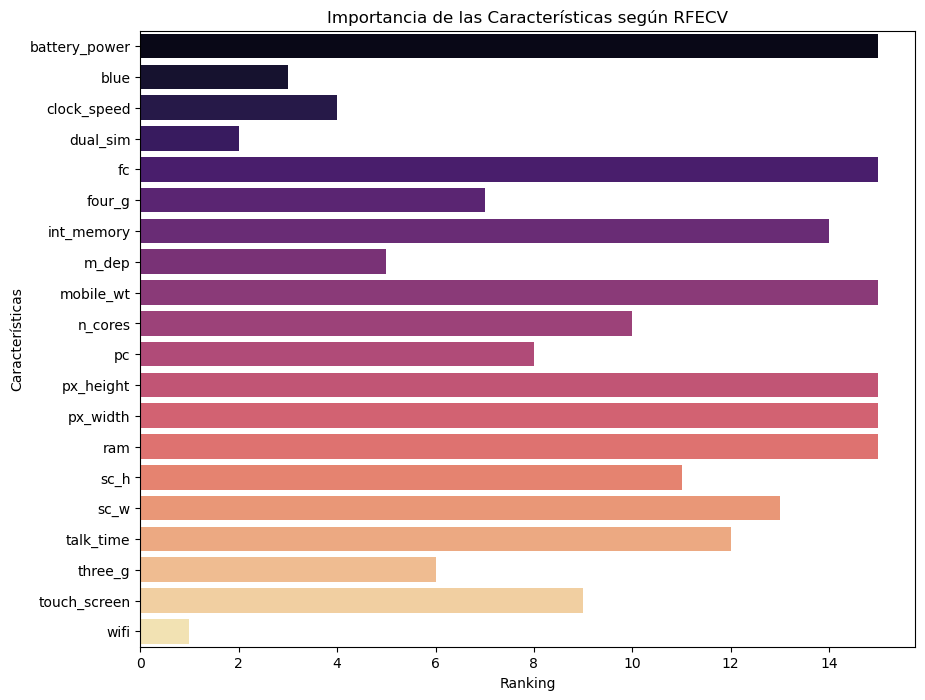

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Ranking', y='Attribute Name', data=scores.sort_values('Attribute Name'), palette='magma')
plt.title('Importancia de las Características según RFECV')
plt.xlabel('Ranking')
plt.ylabel('Características')
plt.show()

el RFECV  seleccionaría sólo las primeras 6 variables contando categóricas y númericas. La reducción de la dimensionalidad es mucho más alta que la del PCA.

Podemos ver cierta discrepancia entre lo que arroja feature_importances_ y RFECV. <br>
En su top 5 solo coiciden en battery_power y mobile_wt
* Top 5 de feature_importances_: pc, battery_power, mobile_wt, n_cores, four_g.
* Top 5 de RFECV (soportadas): battery_power, fc, ram, px_width, mobile_wt.

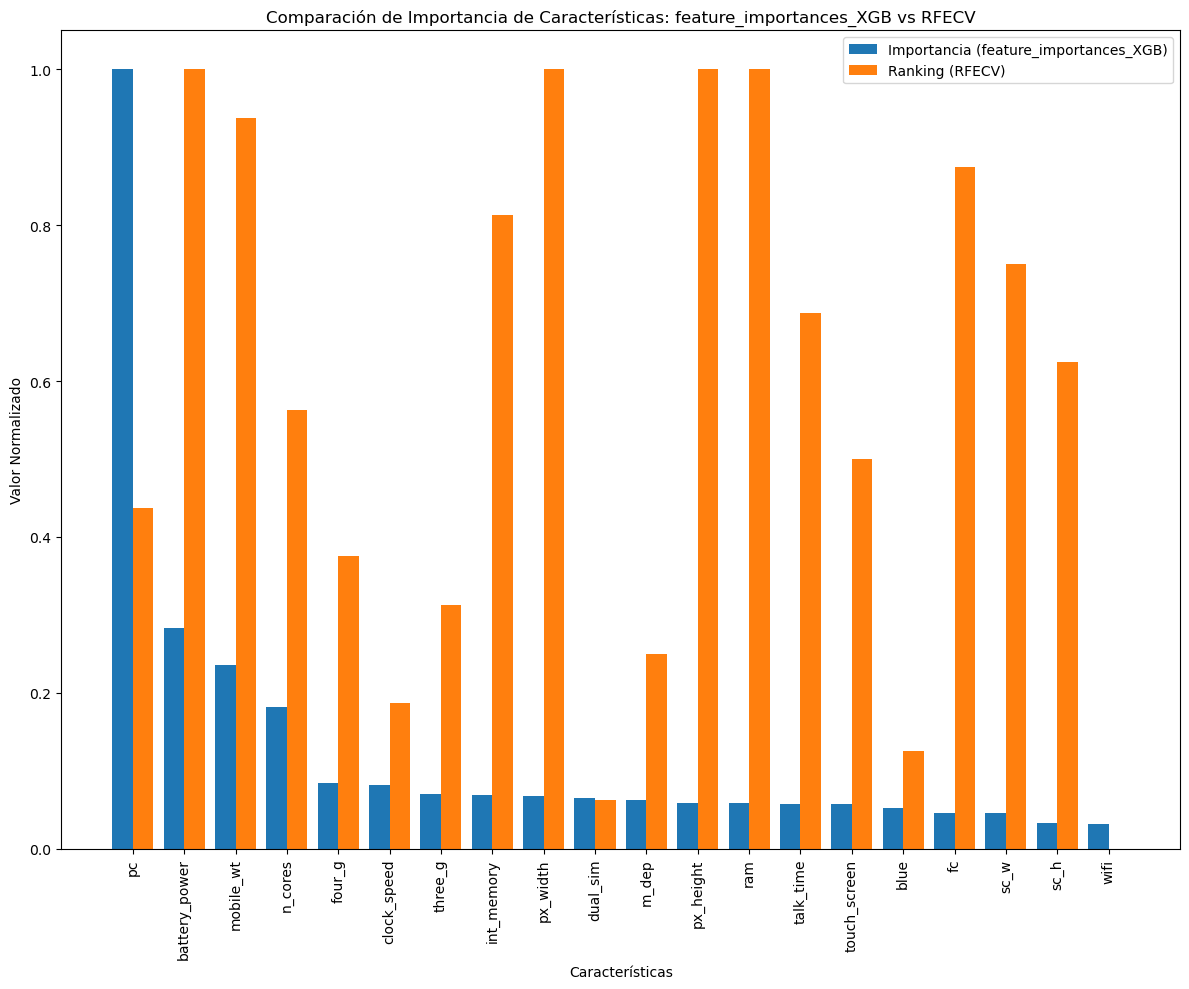

In [ ]:
rf_select = pd.DataFrame({'atributo': X.columns, 'importancia': randomized.best_estimator_['XGB'].feature_importances_})
rf_select = rf_select.sort_values('importancia', ascending=False).reset_index(drop=True)
scores = pd.DataFrame()
scores["Attribute Name"] = X.columns
scores["Ranking"] = rfecv.ranking_
scores["Support"] = rfecv.support_
scores = scores.sort_values('Ranking').reset_index(drop=True)
rf_select['importancia_normalizada'] = rf_select['importancia'] / rf_select['importancia'].max()
scores['ranking_normalizado'] = 1 - (scores['Ranking'] - 1) / (scores['Ranking'].max() - 1)
combined_df = rf_select.merge(scores, left_on='atributo', right_on='Attribute Name', how='outer')
plt.figure(figsize=(12, 10))
width = 0.4  

indices = np.arange(len(combined_df))

plt.bar(indices - width/2, combined_df['importancia_normalizada'], width, label='Importancia (feature_importances_XGB)')

# Barras de ranking
plt.bar(indices + width/2, combined_df['ranking_normalizado'], width, label='Ranking (RFECV)')

# Etiquetas y título
plt.xlabel('Características')
plt.ylabel('Valor Normalizado')
plt.title('Comparación de Importancia de Características: feature_importances_XGB vs RFECV')
plt.xticks(indices, combined_df['atributo'], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()